<a href="https://colab.research.google.com/github/wjdrnqja9/TIL/blob/main/eda/PUBG_Mini_PJT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project

## 프로젝트 설명

- 머신러닝 워크플로우를 완벽하기 이해하고 사용하기 위한 프로젝트입니다.
- Kaggle의 PUBG 순위 예측 대회 데이터를 사용합니다.

## 데이터 설명

- PUBG 게임에서는 각 매치(matchId)에 최대 100명의 플레이어가 시작합니다. 
- 플레이어는 탈락한 다른 팀이 얼마나 생존해 있는지를 기준으로 게임 종료 시 순위(winPlacePerc)가 매겨지는 팀(groupId)에 속할 수 있습니다. 
- 게임에서 플레이어는 다양한 무기를 집어들고, 죽지 않은(knocked) 동료들을 되살리고, 차량을 운전하고, 수영하고, 뛰고, 쏘고, 모든 결과를 경험할 수 있습니다.
- 예를 들어 너무 멀리 떨어지거나, 멀리서 달려오다가(자기장 밖에서) 스스로 죽는 것입니다.

- 각 행에 한 플레이어의 post-game 통계를 포함하도록 포맷된 익명화된 PUBG 게임 통계를 다수 제공합니다. 
- 데이터는 모든 타입(솔로, 듀오, 스쿼드, 커스텀 등)의 매치에서 가져옵니다.
- 경기당 100명 또는 그룹당 최대 4명의 플레이어가 있다는 보장은 없습니다.

- 1(1위)부터 0(1위)까지의 scaling 된, 최종 통계를 기준으로 선수의 결승 배치를 예측하는 모델을 만들어야 합니다.

## 변수 설명

- **Id** - 플레이어 식별 ID
- **groupId** - 매치 내에서 그룹을 식별하는 정수 ID. 같은 그룹의 플레이어가 다른 경기에서 플레이하는 경우, 매번 다른 그룹 ID를 가집니다.
- **matchId** - 매치를 식별할 정수 ID. 훈련 세트와 테스트 세트 모두 일치하는 항목이 없습니다.
- **assists** - 이 플레이어가 피해를 입힌 적 플레이어 중 동료에게 살해된 플레이어 수.
- **boosts** - 사용된 부스트(에너지 드링크, 진통제 등) 항목 수.
- **damageDealt** - 총 데미지 량. 참고: 자해 제외.
- **DBNOs** - 넉다운 시킨 플레이어 수.
- **headshotKills** - 헤드샷으로 제거한 적 플레이어의 수.
- **heals** - 사용된 치료키트(붕대, 구급상자 등) 항목 수.
- **killPlace** - 죽은 적 플레이어의 수에 따른 매치 내 순위.
- **killPoints** - 킬 기반 플레이어의 외부 순위. (킬만 생각하는 [Elo](https://ko.wikipedia.org/wiki/%EC%97%98%EB%A1%9C_%ED%8F%89%EC%A0%90_%EC%8B%9C%EC%8A%A4%ED%85%9C) 순위라고 생각하시면 됩니다.)
- **kills** - 제거한 적 플레이어의 수.
- **killStreaks** - 짧은 시간 내에 제거한 적 플레이어 수 중 최대치.
- **longestKill** - 처치(kill) 시 제거한 플레이어와 플레이어의 가장 긴 거리. - 플레이어를 쓰러뜨리고 차를 몰고 도망가면 가장 긴 Kill stat가 발생할 수 있기 때문에 오해의 소지가 있을 수 있습니다.
- **maxPlace** - 매치에서 가장 낮은 순위. 데이터가 순위를 건너뛰기 때문에 이 값은 numGroups와 일치하지 않을 수 있습니다.
- **numGroups** - 우리가 가지고 있는 매치 데이터 내 플레이어 그룹 수.
- **revives** - 이 플레이어가 팀원을 부활시킨 횟수.
- **rideDistance** - 미터 단위로 측정한 차량의 총 주행 거리.
- **roadKills** - 로드킬 횟수.
- **swimDistance** - 미터 단위로 측정한 수영으로 이동한 총 거리.
- **teamKills** - 팀킬 횟수.
- **vehicleDestroys** - 파괴된 차량 수.
- **walkDistance** - 미터 단위로 측정한 도보로 이동한 총 거리.
- **weaponsAcquired** - 주운 무기의 수.
- **winPoints** - 승자 기준 외부 순위. (승자만이 중요한 [Elo](https://ko.wikipedia.org/wiki/%EC%97%98%EB%A1%9C_%ED%8F%89%EC%A0%90_%EC%8B%9C%EC%8A%A4%ED%85%9C) 순위라고 생각하시면 됩니다.)
- **winPlacePerc** - 예측 대상(target). 백분위수 승리 배치로, 1은 1위, 0은 경기 꼴찌에 해당합니다. 이 값은 numGroups가 아닌 maxPlace에서 계산되므로, 매체에 누락된 chunks(상당한 양)가 있을 수 있습니다.

# EDA

## 데이터

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
# pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', 1000)

In [ ]:
viridis = sns.color_palette("viridis_r")
oranges = sns.color_palette("Oranges")
blues = sns.color_palette("Blues")
pastel1 = sns.color_palette("Pastel1")
set2 = sns.color_palette("Set2")
set3 = sns.color_palette("Set3")
display(viridis)
display(oranges)
display(blues)
display(pastel1)
display(set2)
display(set3)

[(0.626579, 0.854645, 0.223353),
 (0.288921, 0.758394, 0.428426),
 (0.122312, 0.633153, 0.530398),
 (0.153364, 0.497, 0.557724),
 (0.212395, 0.359683, 0.55171),
 (0.275191, 0.194905, 0.496005)]

[(0.9955709342560554, 0.8907958477508651, 0.7855132641291811),
 (0.9921568627450981, 0.7769934640522875, 0.5727028066128412),
 (0.9921568627450981, 0.6280507497116494, 0.34226835832372166),
 (0.9648442906574395, 0.47100346020761247, 0.14197616301422528),
 (0.8782929642445213, 0.31990772779700116, 0.024405997693194924),
 (0.6768627450980392, 0.22089965397923875, 0.010749711649365626)]

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

[(0.984313725490196, 0.7058823529411765, 0.6823529411764706),
 (0.7019607843137254, 0.803921568627451, 0.8901960784313725),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (0.8705882352941177, 0.796078431372549, 0.8941176470588236),
 (0.996078431372549, 0.8509803921568627, 0.6509803921568628),
 (1.0, 1.0, 0.8),
 (0.8980392156862745, 0.8470588235294118, 0.7411764705882353),
 (0.9921568627450981, 0.8549019607843137, 0.9254901960784314),
 (0.9490196078431372, 0.9490196078431372, 0.9490196078431372)]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [ ]:
dtypes = {
        'assists'           : 'uint8',
        'boosts'            : 'uint8',
        'damageDealt'       : 'float16',
        'DBNOs'             : 'uint8',
        'headshotKills'     : 'uint8', 
        'heals'             : 'uint8',    
        'killPlace'         : 'uint8',    
        'killPoints'        : 'uint16',    
        'kills'             : 'uint8',    
        'killStreaks'       : 'uint8',    
        'longestKill'       : 'float16',
        'matchDuration'     : 'uint8',
        'maxPlace'          : 'uint8',    
        'numGroups'         : 'uint8',    
        'rankPoints'        : 'uint8',
        'revives'           : 'uint8',    
        'rideDistance'      : 'float16',    
        'roadKills'         : 'uint8',    
        'swimDistance'      : 'float16',    
        'teamKills'         : 'uint8',    
        'vehicleDestroys'   : 'uint8',    
        'walkDistance'      : 'float16',    
        'weaponsAcquired'   : 'uint8',    
        'winPoints'         : 'uint8', 
        'winPlacePerc'      : 'float16' 
}

In [ ]:
train = pd.read_csv('../data/train_V2.csv', dtype=dtypes)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          uint8  
 4   boosts           uint8  
 5   damageDealt      float16
 6   DBNOs            uint8  
 7   headshotKills    uint8  
 8   heals            uint8  
 9   killPlace        uint8  
 10  killPoints       uint16 
 11  kills            uint8  
 12  killStreaks      uint8  
 13  longestKill      float16
 14  matchDuration    uint8  
 15  matchType        object 
 16  maxPlace         uint8  
 17  numGroups        uint8  
 18  rankPoints       uint8  
 19  revives          uint8  
 20  rideDistance     float16
 21  roadKills        uint8  
 22  swimDistance     float16
 23  teamKills        uint8  
 24  vehicleDestroys  uint8  
 25  walkDistance     float16
 26  weaponsAcquired  uint8  
 27  winPoints   

In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


- Id, groupId, matchId 는 비공개 데이터
- 드랍해도 상관없을 것 같습니다

## Kill

In [ ]:
sns.set_theme(style="whitegrid", palette="Oranges")

In [ ]:
print(f"평균 킬 : {train['kills'].mean()}")
print(f"상위 1퍼 : {train['kills'].quantile(0.99)}")
print(f"MAX 킬 : {train['kills'].max()}")

평균 킬 : 0.9247833241810259
상위 1퍼 : 7.0
MAX 킬 : 72


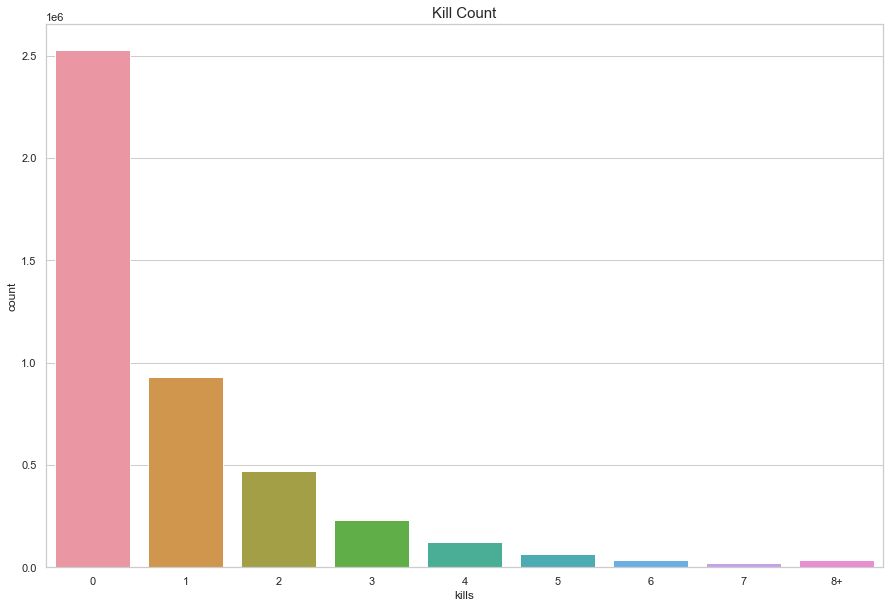

In [ ]:
data = train.copy()
data.loc[data['kills']>data['kills'].quantile(0.99)] = '8+'

plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype(str).sort_values())
plt.title('Kill Count', fontsize=15)
plt.show()

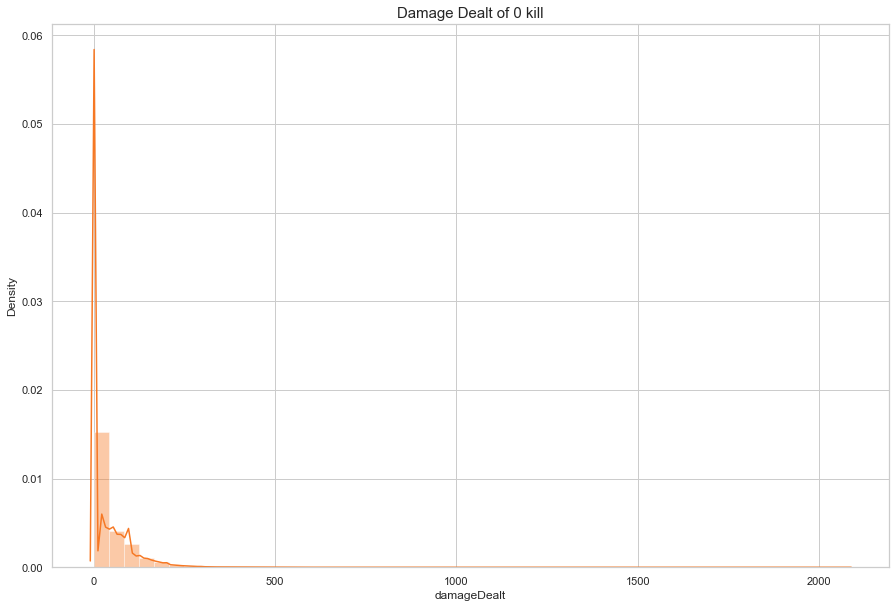

In [ ]:
data = train.copy()
data = data[data['kills']==0]

plt.figure(figsize=(15,10))
sns.distplot(data['damageDealt'], color=oranges[3])
plt.title('Damage Dealt of 0 kill', fontsize=15)
plt.show()

In [ ]:
print(f"{len(data[data['winPlacePerc']==1])}\t명의 플레이어가\t({100*len(data[data['winPlacePerc']==1])/len(train):.4f}%) 킬 없이 우승")

data1 = train[train['damageDealt'] == 0].copy()
print(f"{len(data1[data1['winPlacePerc']==1])}\t명의 플레이어가  \t({100*len(data1[data1['winPlacePerc']==1])/len(train):.4f}%) 데미지 없이 우승")

16666	명의 플레이어가	(0.3748%) 킬 없이 우승
4770	명의 플레이어가  	(0.1073%) 데미지 없이 우승


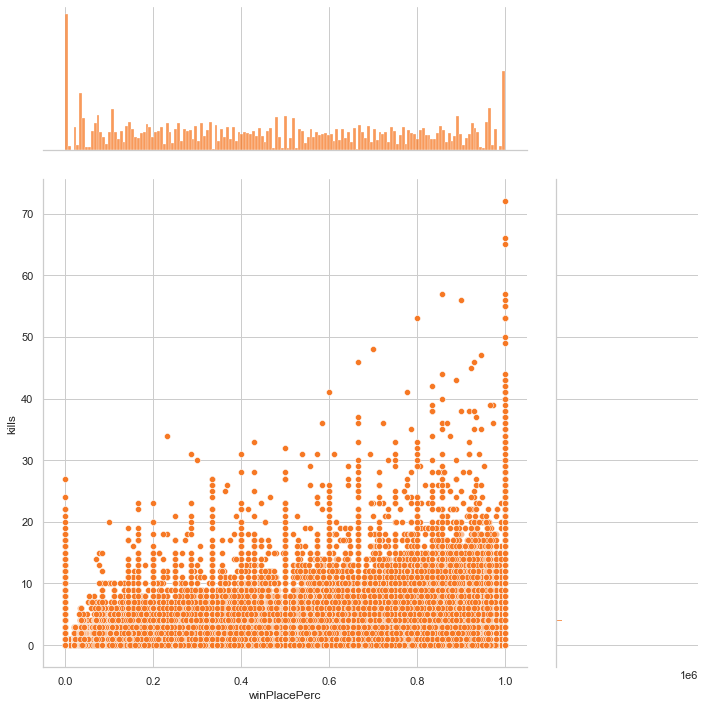

In [ ]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color=oranges[3])
plt.show()

- **`kills`**는 **`winPlacePerc`**사이에는 좀 높은 상관관계가 있습니다.
- (0킬, 1-3킬, 4-6킬, 7-9킬, 10+킬)을 기준으로 그룹화합니다.

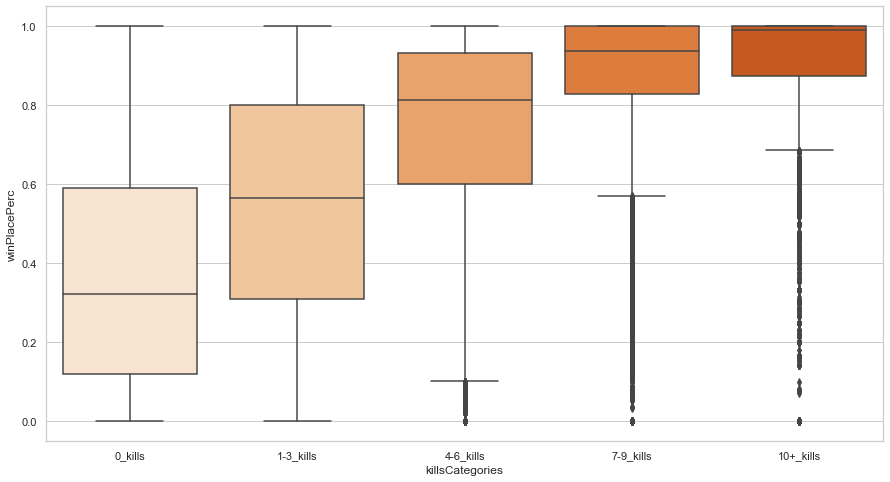

In [ ]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 72], labels=['0_kills','1-3_kills', '4-6_kills', '7-9_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

## Walk

In [ ]:
sns.set_theme(style="whitegrid", palette="viridis_r")

In [ ]:
print(f"평균 도보 거리 : {train['walkDistance'].mean():.1f}m")
print(f"상위 1% : {train['walkDistance'].quantile(0.99):.1f}m")
print(f"MAX 도보 거리 : {train['walkDistance'].max():.1f}m")

평균 도보 거리 : 1154.2m
상위 1% : 4396.0m
MAX 도보 거리 : 25780.0m


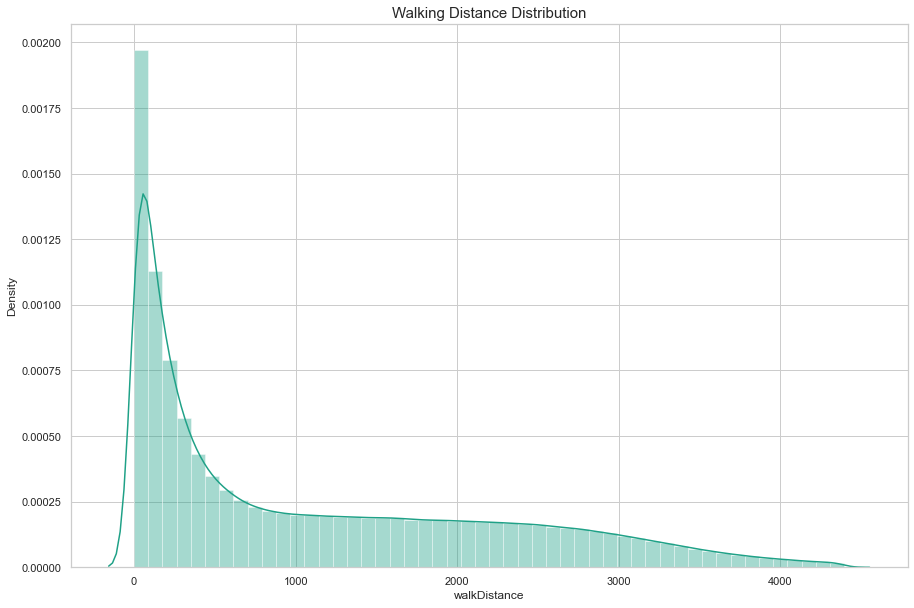

In [ ]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'], color=viridis[2])
plt.show()

In [ ]:
print(f"{len(data[data['walkDistance'] == 0])}명의 플레이어가 ({100*len(data1[data1['walkDistance']==0])/len(train):.4f}%) 0미터를 걸었습니다.")

99603명의 플레이어가 (2.0329%) 0미터를 걸었습니다.


- 이것은 한 발자국도 내딛지 못하고 죽거나 혹은 그들이 뒷걸음질 친다는 것을 의미합니다.

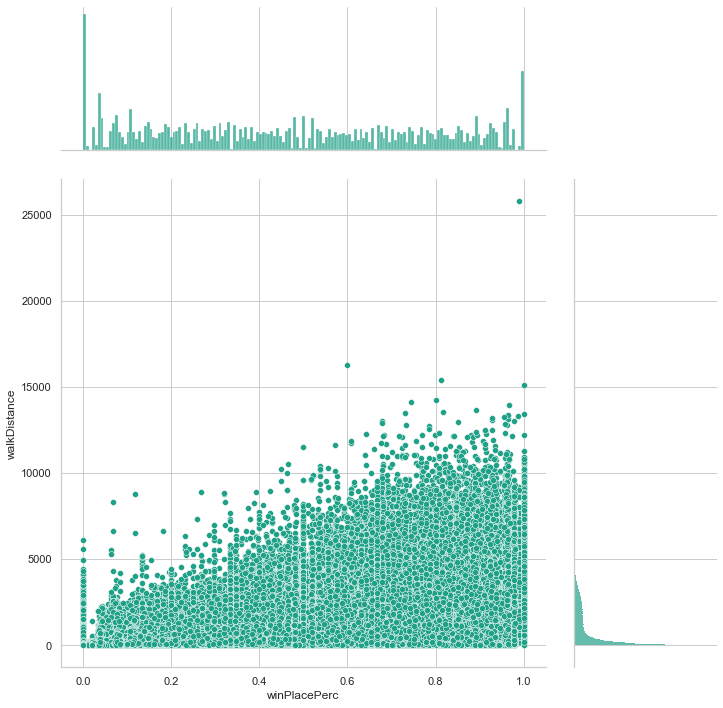

In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color=viridis[2])
plt.show()

- `winPlacePerc`와 `walkDistance` 사이에는 좀 높은 상관관계가 있습니다.

## Ride

In [ ]:
sns.set_theme(style="whitegrid", palette="Oranges")

In [ ]:
print(f"평균 주행거리 : {train['rideDistance'].mean():.1f}m")
print(f"상위 1퍼 : {train['rideDistance'].quantile(0.99):.1f}m")
print(f"MAX 주행거리 : {train['rideDistance'].max():.1f}m")

평균 주행거리 : 606.1m
상위 1퍼 : 6966.0m
MAX 주행거리 : 40710.0m


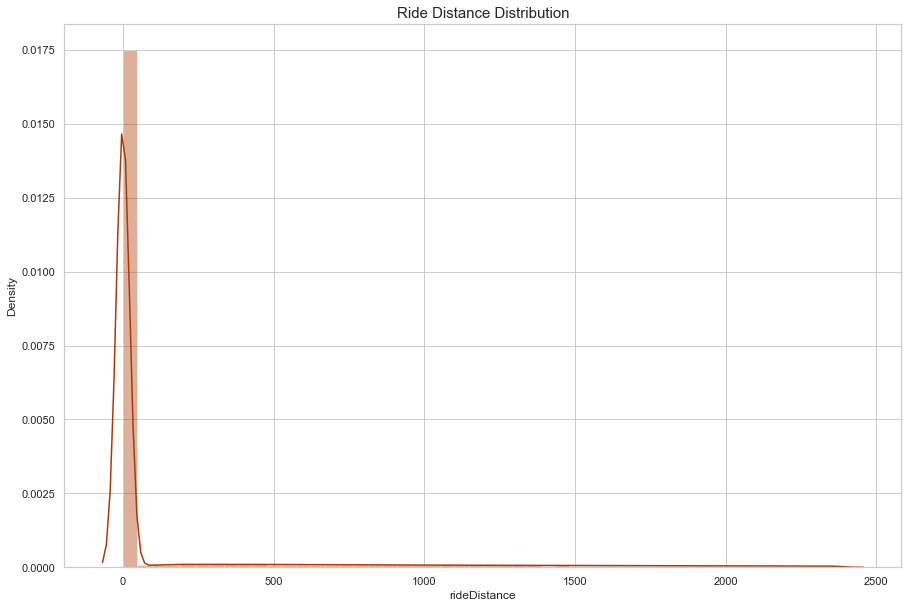

In [ ]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'], color=oranges[5])
plt.show()

In [ ]:
print(f"{len(data[data['rideDistance'] == 0])}명의 플레이어는 ({100*len(data1[data1['rideDistance']==0])/len(train):.4f}%) 0미터를 주행했습니다.")

3309429명의 플레이어는 (23.1022%) 0미터를 주행했습니다.


- 이것은 차량을 탑승하지 않았다는 말입니다.

In [ ]:
# sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color=oranges[5])
# plt.show()

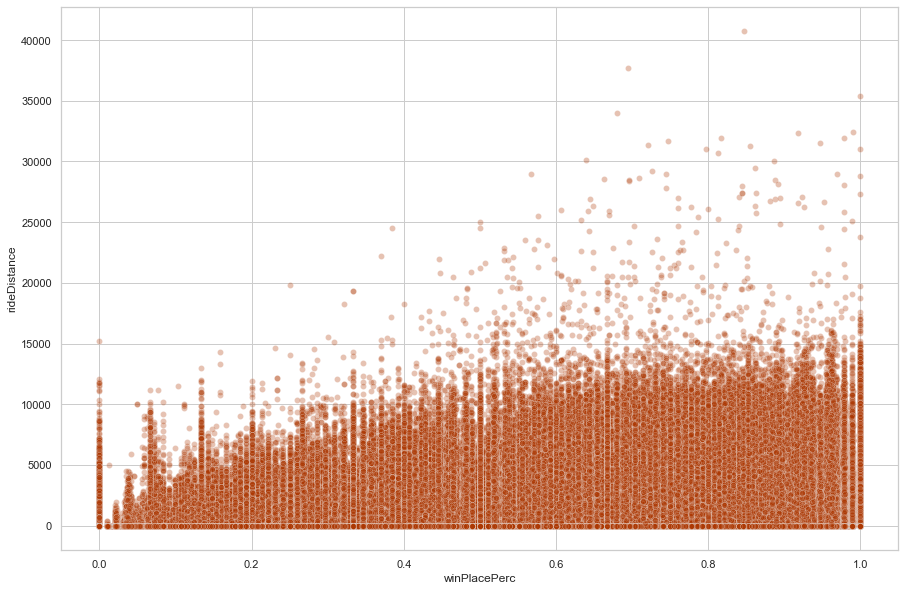

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x="winPlacePerc", y="rideDistance", data=train, color=oranges[5], alpha=0.3)
plt.show()

- `winPlacePerc`와 `rideDistance` 사이에는 약간 상관관계가 있습니다.

## Destroy a vehicle

- 차량을 파괴하는 것은 플레이어가 기술을 가지고 있다는 것을 보여줍니다.

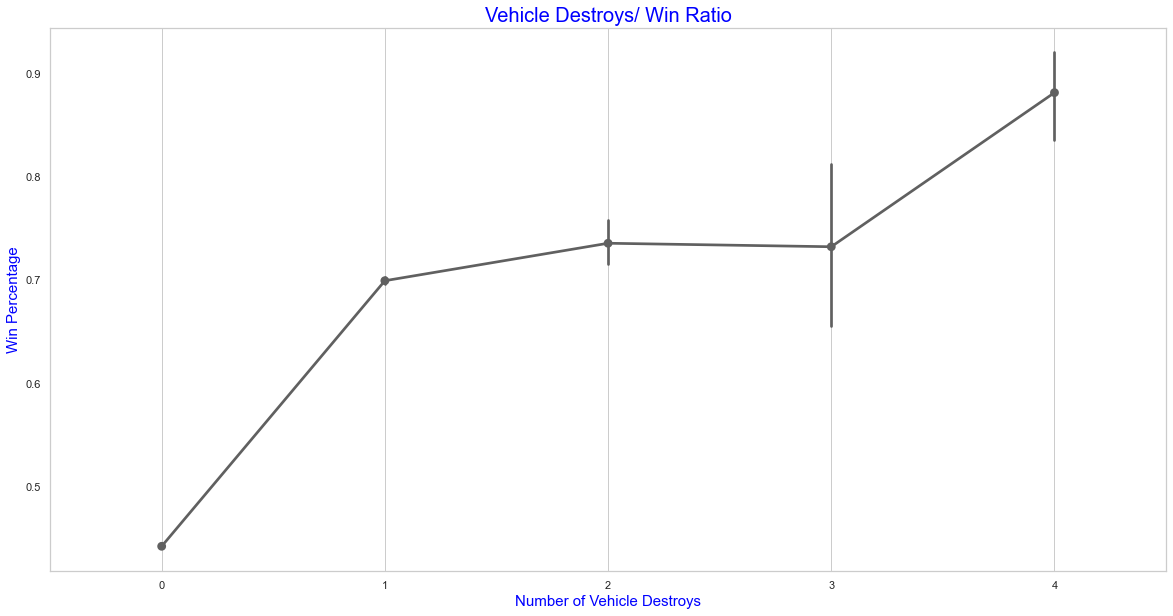

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

- 차량 한 대를 파괴하면 승산이 높아집니다.

## Swim

In [ ]:
sns.set_theme(style="whitegrid", palette="Blues")

In [ ]:
print(f"평균 수영거리 : {train['swimDistance'].mean():.1f}m")
print(f"상위 1퍼 : {train['swimDistance'].quantile(0.99):.1f}m")
print(f"MAX 수영거리 : {train['swimDistance'].max():.1f}m")

평균 수영거리 : 4.5m
상위 1퍼 : 123.0m
MAX 수영거리 : 3823.0m


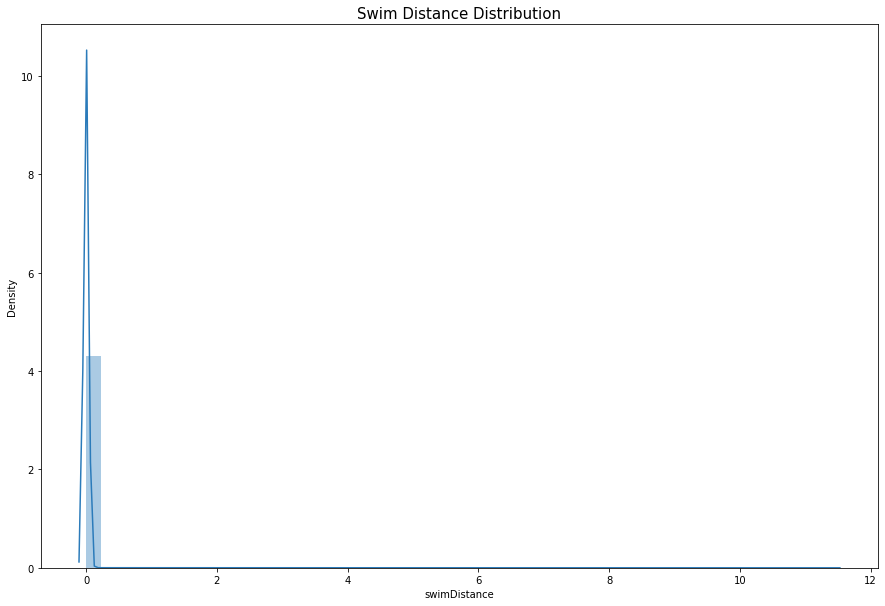

In [ ]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'], color=blues[4])
plt.show()

- 거의 아무도 수영하지 않습니다. 
- 수영 거리를 4개 그룹으로 나누어 winPlacePerc과 관계 plot을 그려보겠습니다.

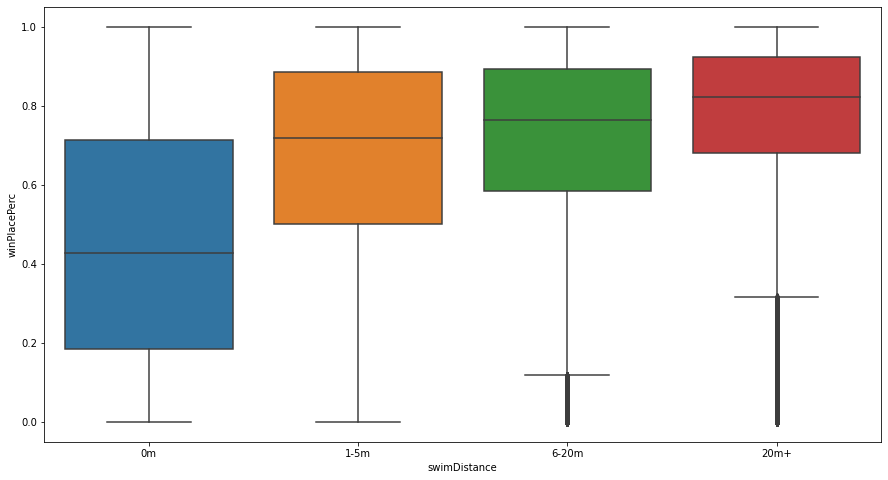

In [ ]:
swim = train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

- 수영을 하면 정상에 오르는 것 같습니다. 하지만
- **PUBG에 몇개의 맵은 물이 거의 없습니다.**

## Heal

In [ ]:
print(f"평균 힐링 횟수 : {train['heals'].mean():.1f}번")
print(f"상위 1퍼 : {train['heals'].quantile(0.99)}번")
print(f"MAX 힐링 횟수 : {train['heals'].max()}번")

평균 힐링 횟수 : 1.4번
상위 1퍼 : 12.0번
MAX 힐링 횟수 : 80번


In [ ]:
print(f"평균 부시팅 횟수 : {train['boosts'].mean():.1f}번")
print(f"상위 1퍼 : {train['boosts'].quantile(0.99):.1f}번")
print(f"MAX 도핑 횟수 : {train['boosts'].max()}번")

평균 부시팅 횟수 : 1.1번
상위 1퍼 : 7.0번
MAX 도핑 횟수 : 33번


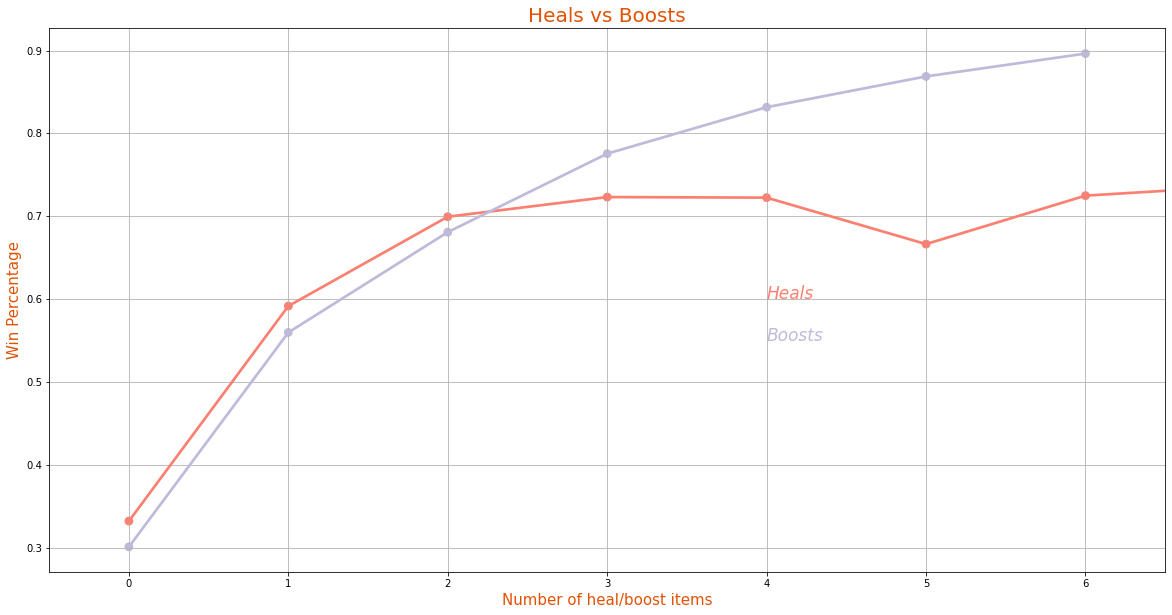

In [ ]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals', y='winPlacePerc', data=data, color=set3[3])
sns.pointplot(x='boosts', y='winPlacePerc', data=data, color=set3[2])
plt.text(4,0.6,'Heals', color=set3[3], fontsize = 17, style = 'italic')
plt.text(4,0.55,'Boosts', color=set3[2], fontsize = 17, style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color=oranges[-2])
plt.ylabel('Win Percentage',fontsize = 15,color=oranges[-2])
plt.title('Heals vs Boosts',fontsize = 20,color=oranges[-2])
plt.grid()
plt.show()

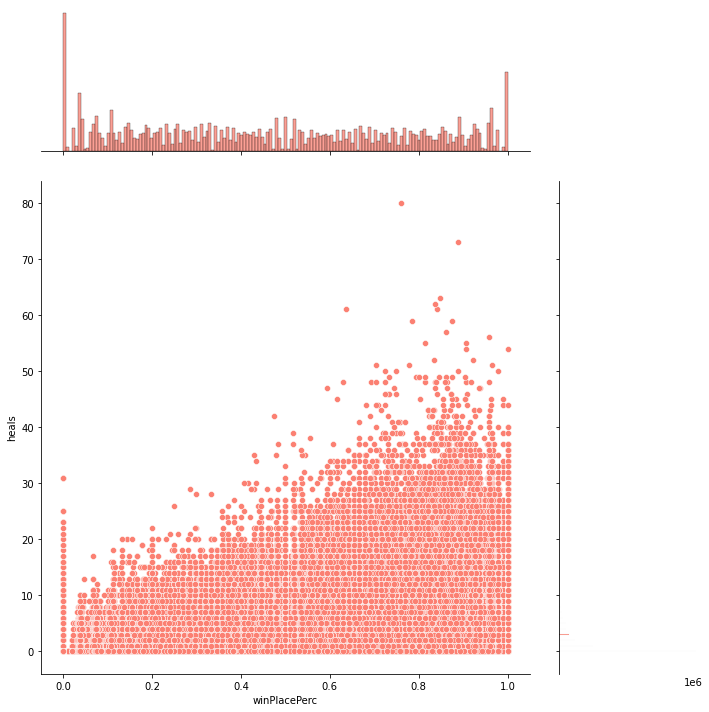

In [ ]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color=set3[3])
plt.show()

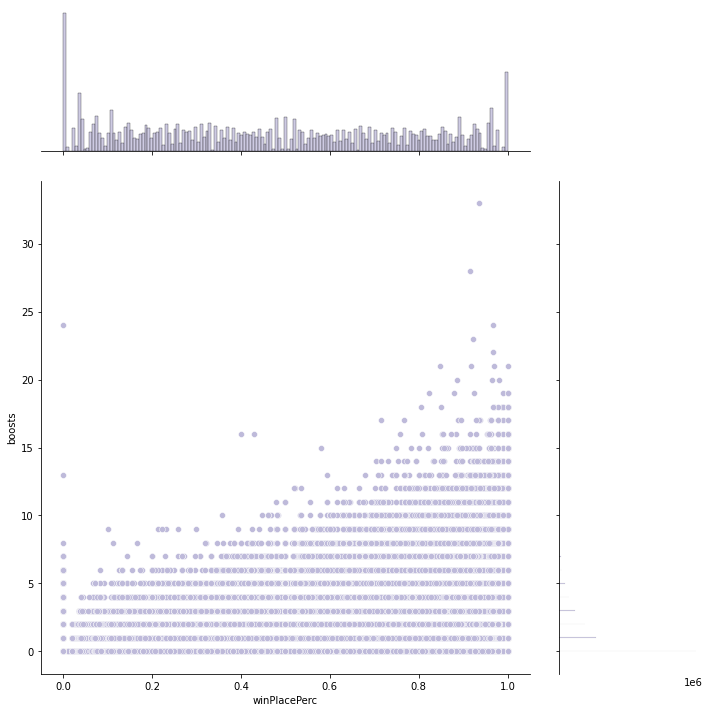

In [ ]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color=set3[2])
plt.show()

- 힐링과 부스팅은 확실히 winPlacePerc와 관련이 있습니다.
- 부스팅은 그 이상입니다.

- 모든 그래프에서 값이 0일 때 이상치가 발생합니다.

## Solos, Duos and Squads

- 게임에는 세 가지 게임 모드가 있습니다. 솔로(1명), 듀오(1-2명), 스쿼드(1-4명)
- 최대 100명의 플레이어가 같은 서버에 들어오기 때문에 듀오의 경우 최대 50팀, 스쿼드의 경우 최대 25팀입니다.

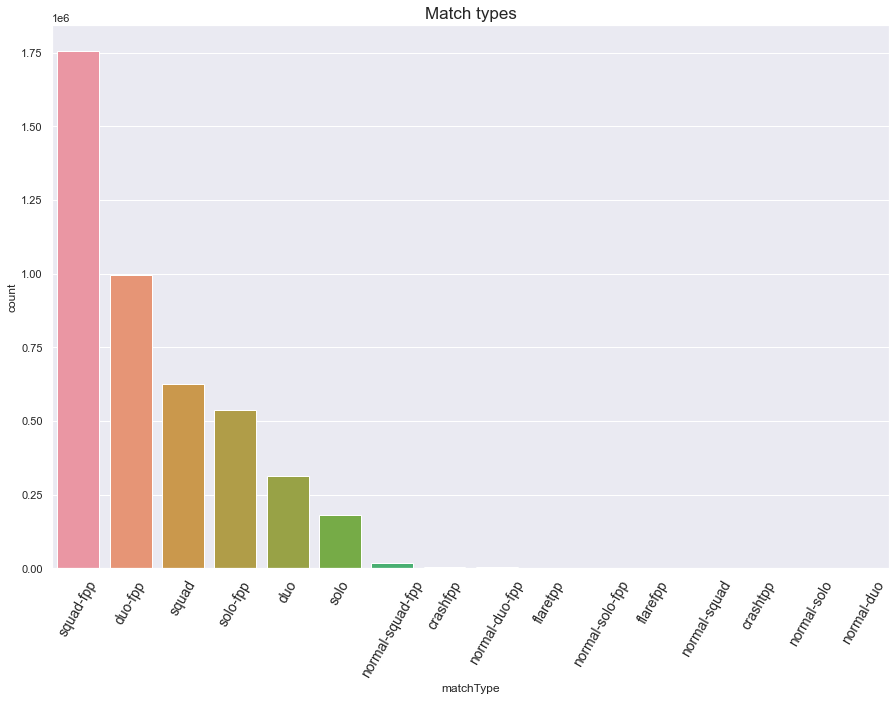

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x='matchType', data=train, order = train['matchType'].value_counts().index)
plt.xticks(rotation=60, fontsize=14)
plt.title("Match types", fontsize=17)
plt.show()

- flaretpp와 crashtpp는 이벤트 모드에 있어야하며, 보통 솔로와 유사합니다.

**flare(플레어 건)**
- 플레어 건을 얻을 수 있습니다. 
- 플레어 건은 하늘을 향해 발사되는 일종의 신호입니다. 
- 해당 위치에 플레어 건이 사용될 때 비행기가 보급 상자(Care Package)를 공급하는 특수 화기입니다.

**crash(크래쉬 캐니지)**
- Road scary는 연료와 불이 왕인 이벤트 모드입니다.
- 크래쉬 캐니지에는 화기가 없고, 근접 무기와 드론이 있습니다. 
- 당신의 듀오를 결승전에 진출시킬 수 있는 운전 스킬에 집중해야 합니다. 
- 그리고 자기장은 빠르게 줄어듭니다. 그래서 모든 과정이 빠르게 이루어져야 합니다.

In [ ]:
train.loc[:, "team"] = 0 # solo, duo, squad가 아닌 나머지는 0(이벤트 모드)
train.loc[train['matchType'].isin(["solo-fpp","solo","normal-solo-fpp","normal-solo"]), 'team']= 1
train.loc[train['matchType'].isin(["duo-fpp","duo","normal-duo-fpp","normal-duo"]), 'team'] = 2
train.loc[train['matchType'].isin(["squad-fpp","squad","normal-squad-fpp","normal-squad"]), 'team'] = 3

In [ ]:
solos = train.loc[train['matchType'].isin(["solo-fpp","solo","normal-solo-fpp","normal-solo"])]
duos = train[train['team']==2]
squads = train[train['team']==3]
events = train[train['team']==0]
print(f"{len(solos)}\t({100*len(solos)/len(train):.2f}%)\tsolo games")
print(f"{len(duos)}\t({100*len(duos)/len(train):.2f}%)\tduo games")
print(f"{len(squads)}\t({100*len(squads)/len(train):.2f}%)\tsquad games")
print(f"{len(events)}\t({100*len(events)/len(train):.2f}%)\t\tevent games")

720713	(16.21%)	solo games
1315970	(29.59%)	duo games
2400402	(53.98%)	squad games
9881	(0.22%)		event games


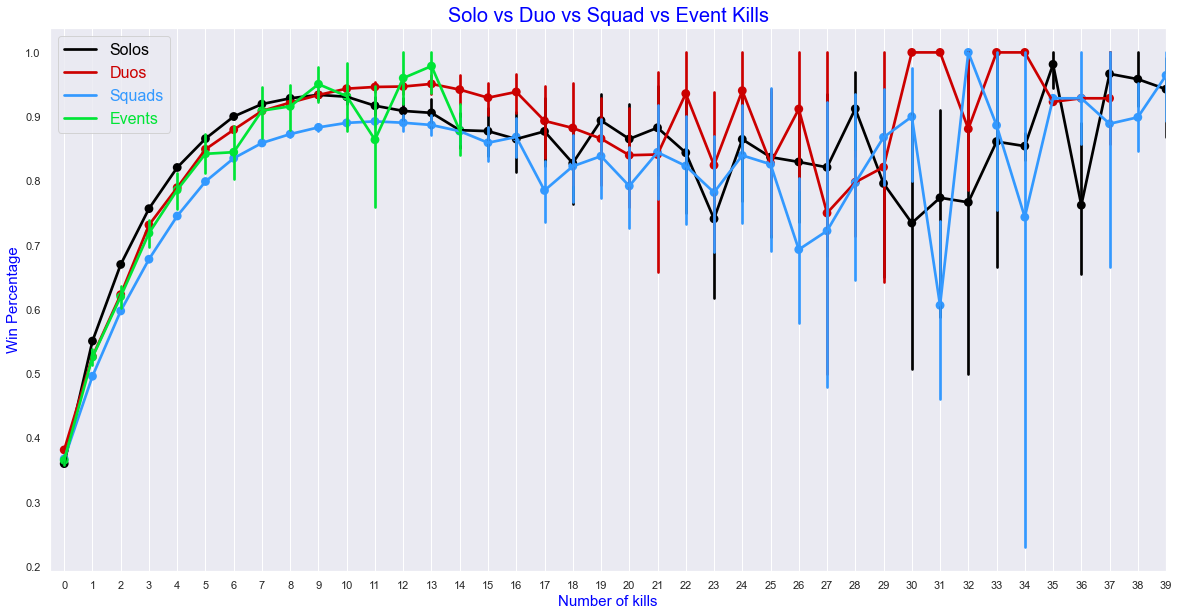

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=events,color='#00E536',alpha=0.8)
plt.legend(labels=['Solos', 'Duos', 'Squads', 'Events'], labelcolor=['black', '#CC0000', '#3399FF', '#00E536'], fontsize=16, loc='best')
leg = ax1.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('#CC0000')
leg.legendHandles[2].set_color('#3399FF')
leg.legendHandles[3].set_color('#00E536')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.xticks(range(40), range(40))
plt.title('Solo vs Duo vs Squad vs Event Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

- 모든 매치의 종류 게임에서 `winPlacePerc`와 비슷한 상관관계를 가지고 있습니다.

## DBNO / Assist / Revive

- `DBNOs` 속성은 적 플레이어가 넉다운을 했다는 의미입니다.
- "Knock"는 듀오, 스쿼드, 이벤트에서만 일어날 수 있는데, 이는 팀원들이 주어진 시간 내에 넉다운당한 플레이어를 "부활"시킬 수 있기 때문입니다.
- `assists`는 듀오, 스쿼드, 이벤트에서만 발생할 수 있습니다. 그것은 일반적으로 그 플레이어가 킬에 관여했다는 것을 의미합니다.
- `revives`도 듀오, 스쿼드, 이벤트에서만 발생합니다.

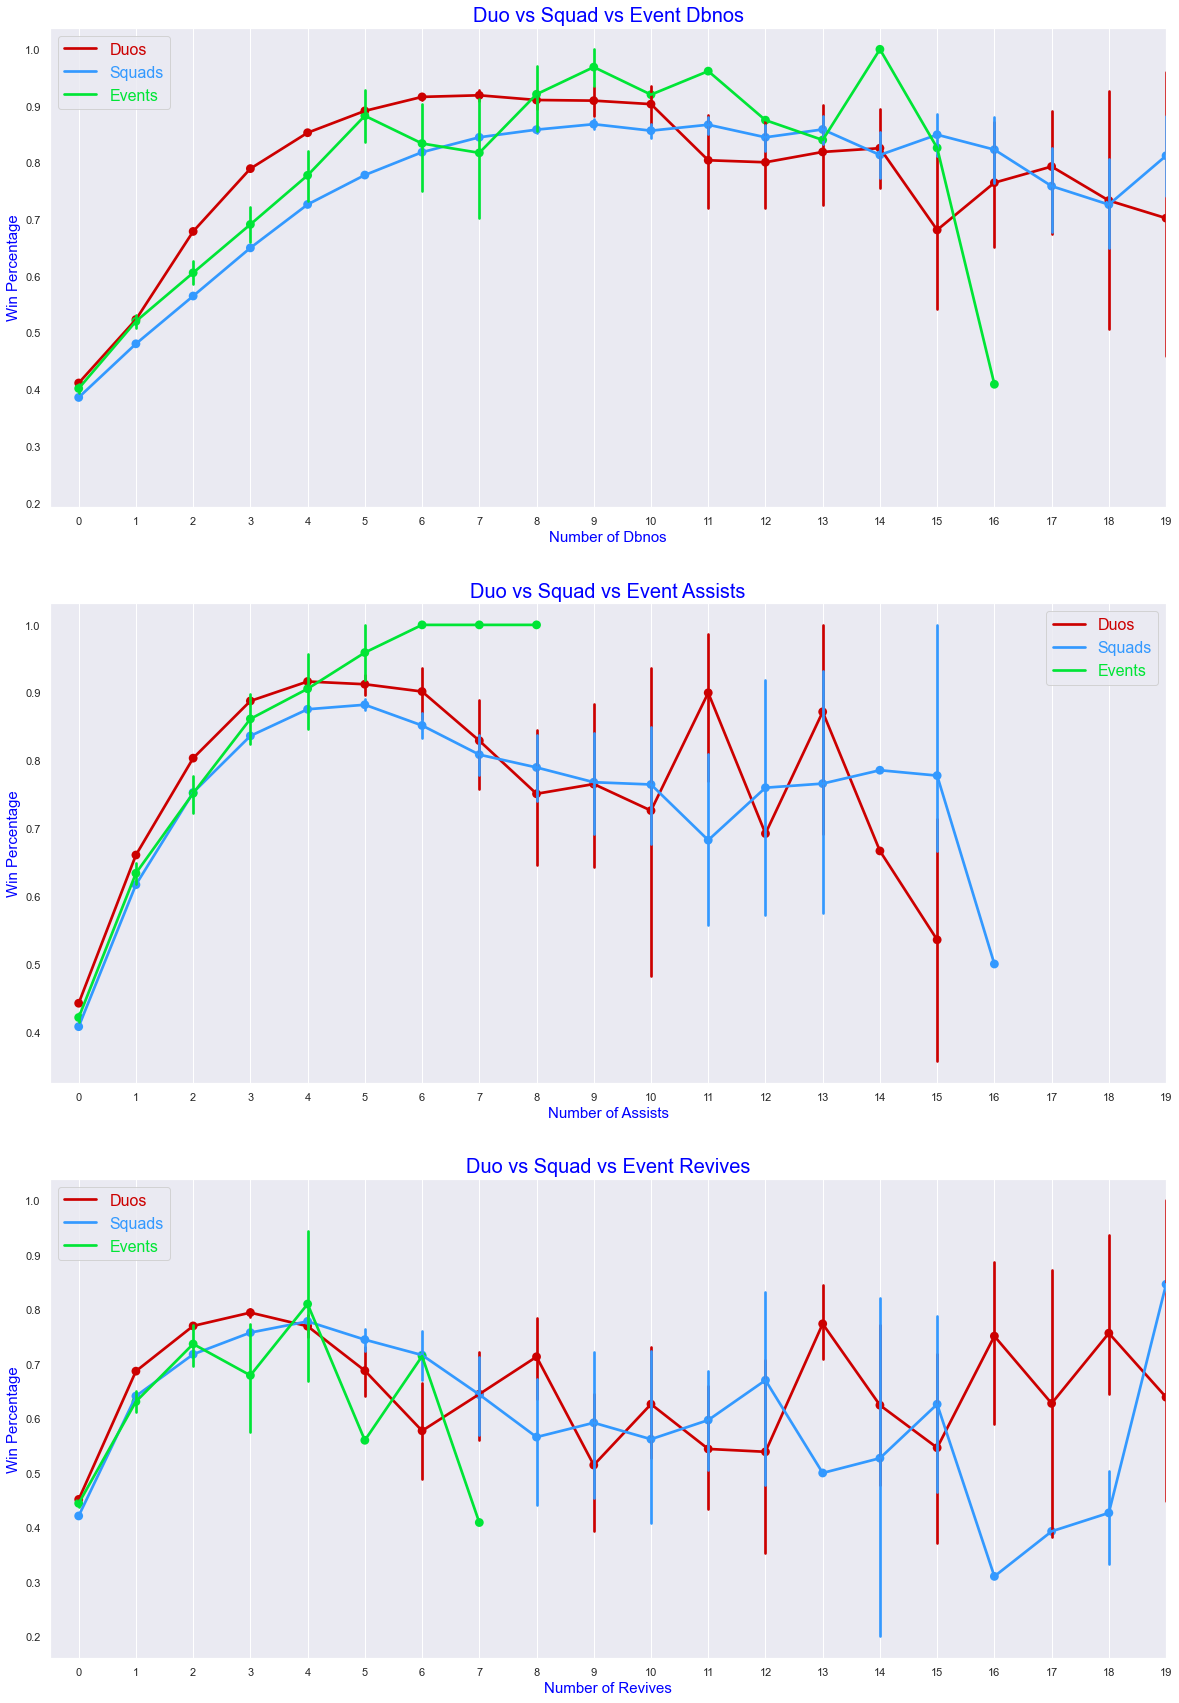

In [ ]:
def plot_ax(col, ax):
    sns.pointplot(x=col,y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8, ax=ax)
    sns.pointplot(x=col,y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8, ax=ax)
    sns.pointplot(x=col,y='winPlacePerc',data=events,color='#00E536',alpha=0.8, ax=ax)
    ax.set_title(f'Duo vs Squad vs Event {col.title()}',fontsize = 20,color='blue')
    ax.set_xlabel(f"Number of {col.title()}",fontsize = 15,color='blue')
    ax.set_ylabel('Win Percentage',fontsize = 15,color='blue')
    ax.set_xticks(range(20),range(20))
    ax.grid()
    ax.legend(labels=['Duos', 'Squads', 'Events'], labelcolor=['#CC0000', '#3399FF', '#00E536'], fontsize=16, loc='best')
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('#CC0000')
    leg.legendHandles[1].set_color('#3399FF')
    leg.legendHandles[2].set_color('#00E536')

f,ax = plt.subplots(nrows=3, ncols=1, figsize =(20,30))

for i, p in enumerate(['DBNOs', 'assists', 'revives']):
    plot_ax(p, ax[i])

plt.show()

- DBNO, Assist, Revive가 많다고 우승할 확률이 높은 것은 아닌것 같습니다.
- `winPlacePerc`와 약간의 상관관계를 가지고 있는 것을 알 수 있습니다.

## Correlation

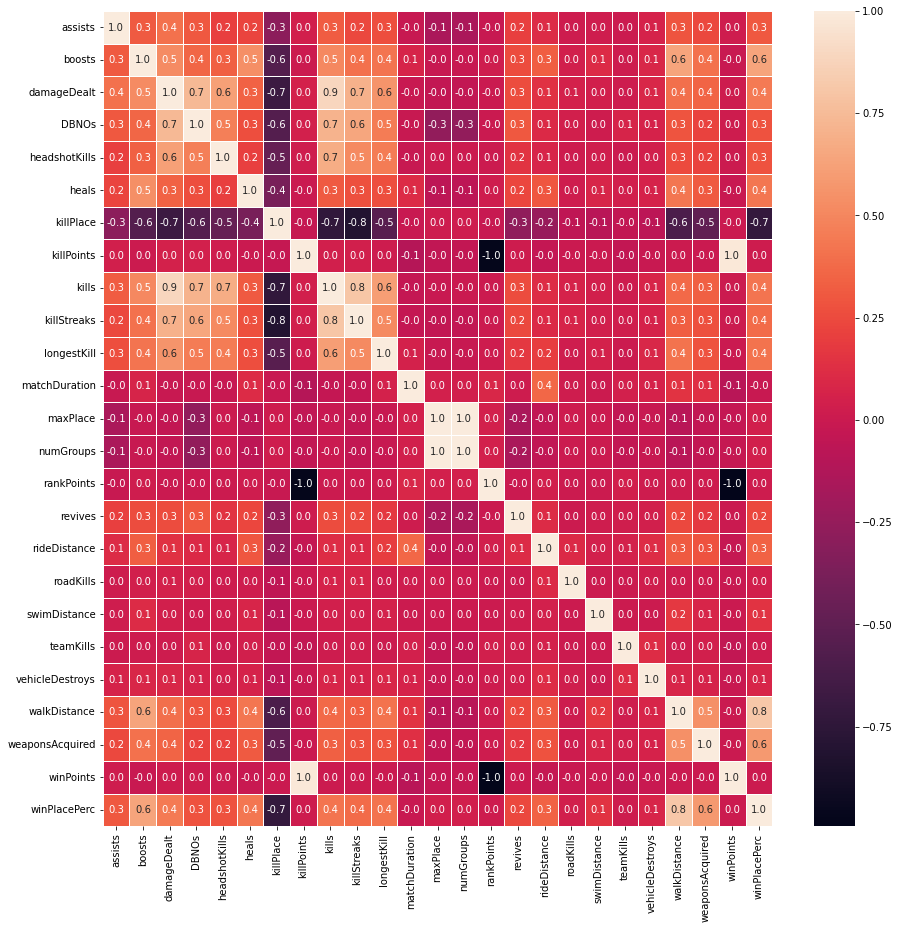

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

- target(winPlacePerc)의 경우 중간에서 높은 상관관계가 있는 column이 몇 가지 있습니다. 
- 가장 높은 양의 상관관계는 walkDistance이고 가장 높은 음의 상관관계는 killPlace입니다.

### Positive correlation variables with target

In [ ]:
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index

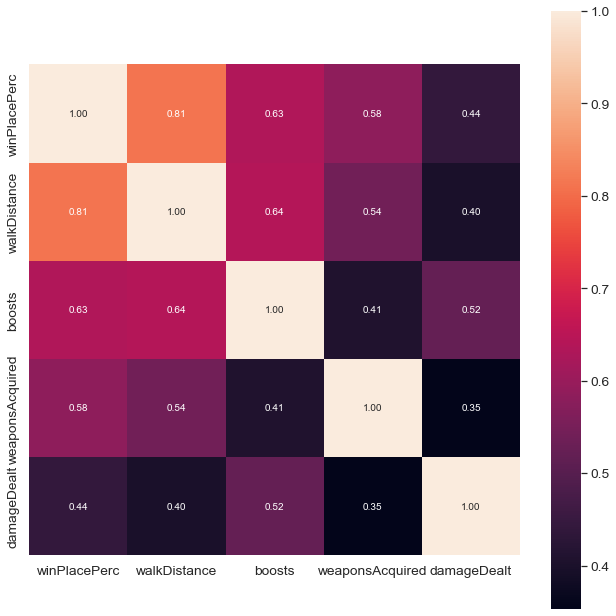

In [ ]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
sns.set(font_scale=1.25)
hm = sns.heatmap(data=train[cols].corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

- 위의 column과 killPlace를 같이 표시합니다.

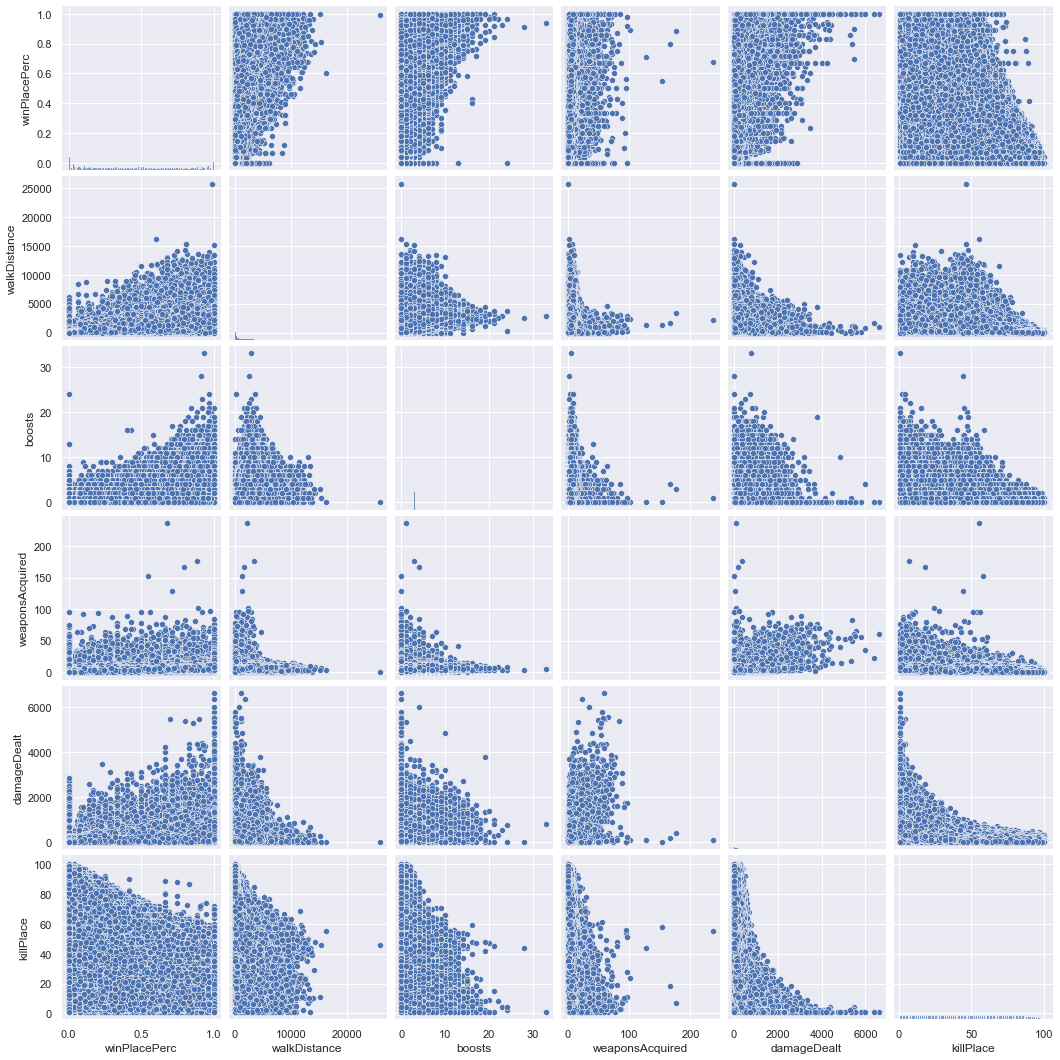

In [ ]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(train[cols], size = 2.5)
plt.show()

## etc.

In [ ]:
from scipy.stats import mode

<AxesSubplot:xlabel='winPlacePerc', ylabel='assists'>

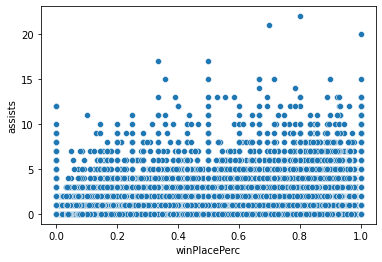

In [ ]:
sns.scatterplot(data=train, x="winPlacePerc", y="assists") #keep

<AxesSubplot:xlabel='winPlacePerc', ylabel='headshotKills'>

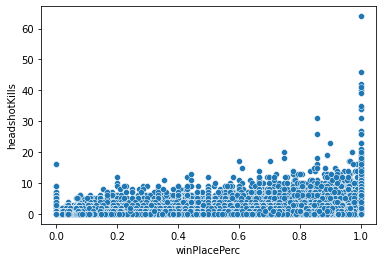

In [ ]:
sns.scatterplot(data=train, x="winPlacePerc", y="headshotKills") #keep

<AxesSubplot:xlabel='winPlacePerc', ylabel='killPlace'>

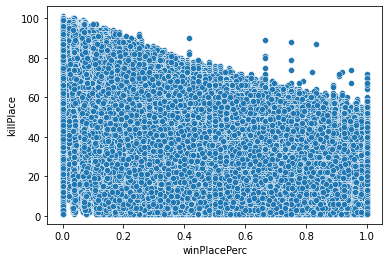

In [ ]:
sns.scatterplot(data=train, x="winPlacePerc", y="killPlace") # keep

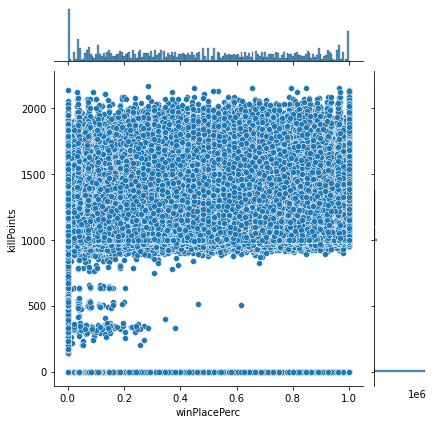

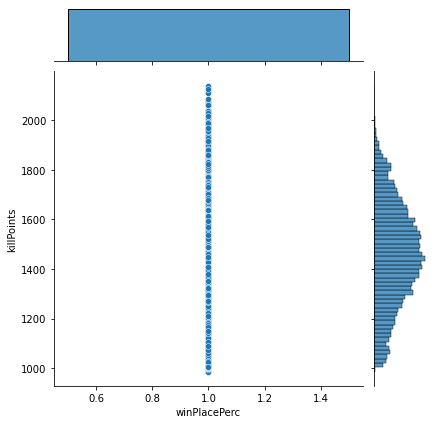

In [ ]:
sns.jointplot(data=train, x="winPlacePerc", y="killPoints") # 관계없다 drop
sns.jointplot(data=train[(train['winPoints']>1500)&(train['winPlacePerc']==1)], x="winPlacePerc", y="killPoints")

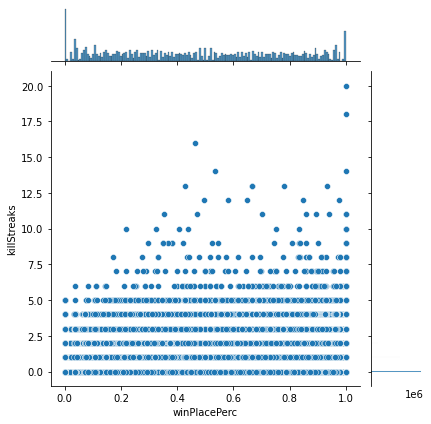

In [ ]:
sns.jointplot(data=train, x="winPlacePerc", y="killStreaks") # keep

<AxesSubplot:xlabel='winPlacePerc', ylabel='longestKill'>

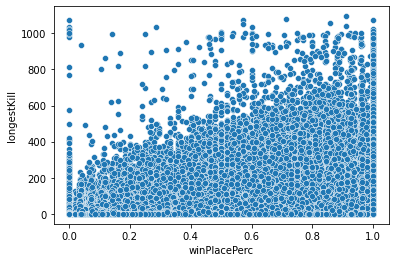

In [ ]:
sns.scatterplot(data=train, x="winPlacePerc", y="longestKill") # keep

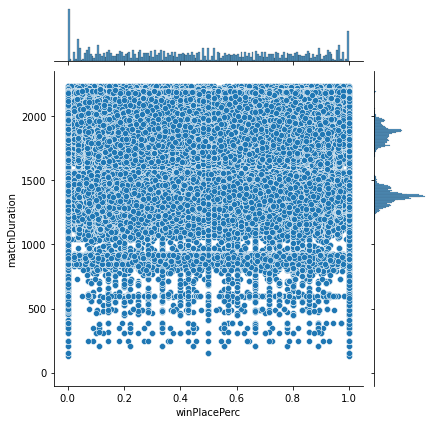

In [ ]:
sns.jointplot(data=train, x="winPlacePerc", y="matchDuration") # drop

<AxesSubplot:xlabel='winPlacePerc', ylabel='numGroups'>

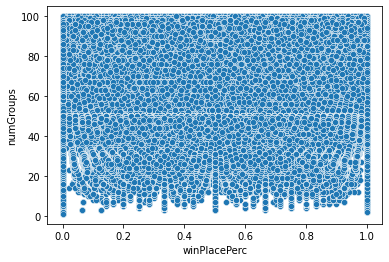

In [ ]:
sns.scatterplot(data=train, x="winPlacePerc", y="numGroups") # drop

<AxesSubplot:xlabel='winPlacePerc', ylabel='maxPlace'>

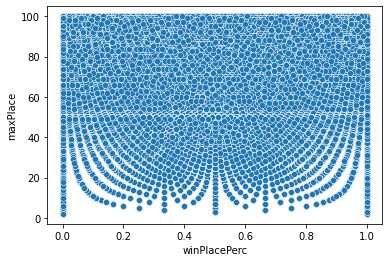

In [ ]:
sns.scatterplot(data=train, x="winPlacePerc", y="maxPlace") # drop

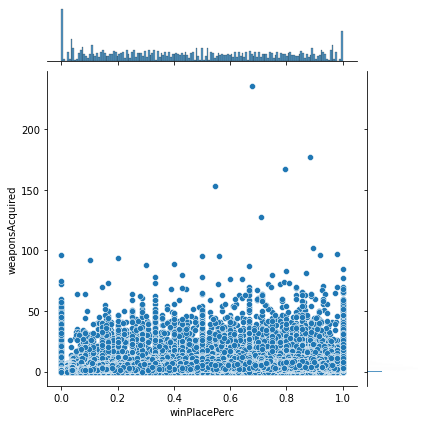

In [ ]:
sns.jointplot(data=train, x="winPlacePerc", y="weaponsAcquired") # drop

In [ ]:
train['winPoints'].value_counts()

0       2655647
1500     153675
1502      18859
1501      18829
1503      18752
         ...   
888           1
913           1
1044          1
1053          1
916           1
Name: winPoints, Length: 1447, dtype: int64

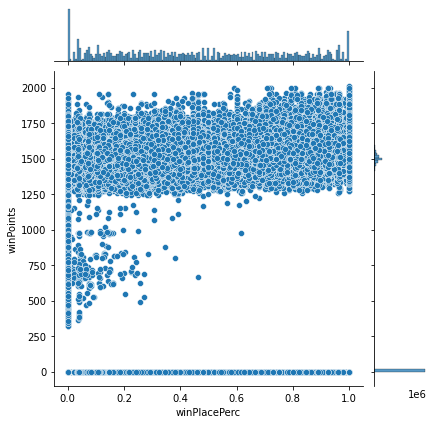

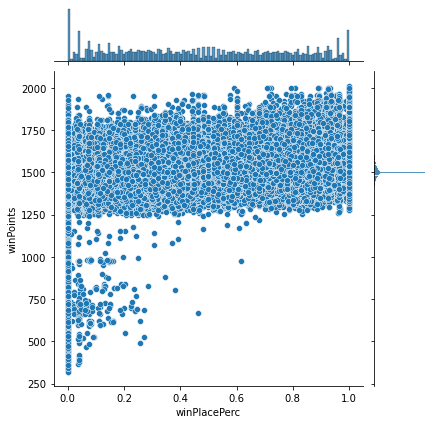

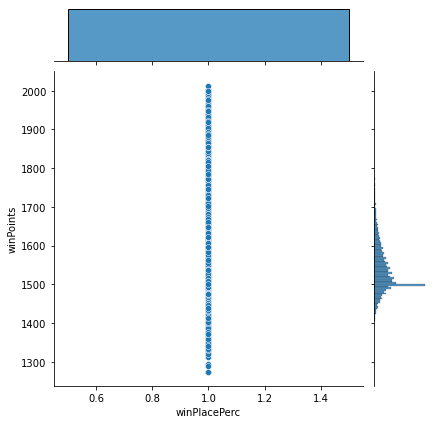

In [ ]:
sns.jointplot(data=train, x="winPlacePerc", y="winPoints") # 이상치(0)가 너무 많다. 0을 1500으로 처리 필요 
sns.jointplot(data=train[train['winPoints']>0], x="winPlacePerc", y="winPoints") # 상관관계 keep
sns.jointplot(data=train[(train['winPoints']>0)&(train['winPlacePerc']==1)], x="winPlacePerc", y="winPoints")

In [ ]:
train[train['winPoints']>0]['winPoints'].value_counts()

1500    153675
1502     18859
1501     18829
1503     18752
1505     18664
         ...  
1213         1
929          1
1228         1
1149         1
916          1
Name: winPoints, Length: 1446, dtype: int64

- 0을 최빈값 1500으로 바꾼다

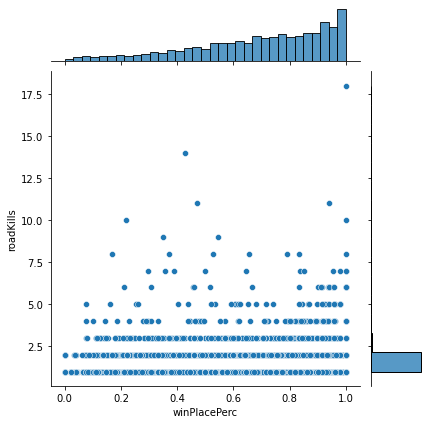

In [ ]:
sns.jointplot(data=train[train['roadKills']>0], x="winPlacePerc", y="roadKills") # 0이 아닐 때 상향관계. keep

# Feature Engineering

- PUBG의 한 게임은 최대 100명의 플레이어가 서로 싸울 수 있습니다.
- 하지만 대부분의 게임은 "Full"이 아닙니다. 들어온 플레이어 수를 알려주는 변수는 없습니다.
- 플레이어가 참가한 게임에 몇명이 게임에 참여했는지 만들어보겠습니다.

In [ ]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

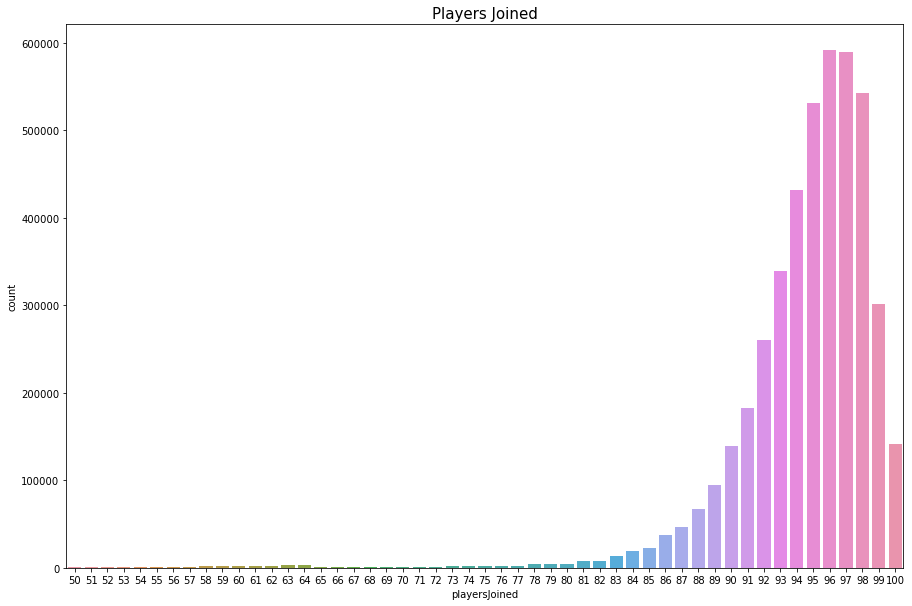

In [ ]:
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

- 참여한 플레이어 수를 가지고 kills와 damageDealt 등 column에 가중치를 부여할 수 있습니다.
- 실제로 게임 내에 100명이 있을 때와 90명이 있을 때 100명이 있을 때가 적을 더 죽이기 쉬울 것입니다.
- 다시 계산을 해본다면 게임에 100명이 참가했을 때 1킬 점수는 1점(그대로)이고 90명이 참가했을 때는 1킬 점수는 (100-90)/100 + 1 = 1.1점입니다.
- 혹은 다르게 가중치를 부여하는 방법도 있을 것입니다.

In [ ]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][5:8]

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
5,95,1,1.05,100.000000,105.000000
6,97,0,0.00,0.000000,0.000000
7,96,0,0.00,8.539062,8.880625


- 또 다른 간단한 특징은 힐링과 부스트의 합계 그리고 주행 총 거리입니다.

In [ ]:
train['healsAndBoosts'] = train['heals']+train['boosts']
train['totalDistance'] = train['walkDistance']+train['rideDistance']+train['swimDistance']

- 부스팅 아이템을 사용하면 더 빨리 달리게 됩니다. 
- 또한 자기장(PUBG 용어)밖에 있으면 더 많이 파밍을 할 수 있습니다(대신 더 많이 움직여야한다는 의미). 
- 그래서 `boostsPerWalkDistance` 특징(feature)를 만들어 보겠습니다. 
- 힐링은 더 빨리 뛰게 하지는 않지만, 자기장밖에서 버틸 수 있게 해주고, 그 덕에 더 많이 파밍을 할 수 있습니다.
- 이제 힐링에도 `healsAndBoostsPerWalkDistance` 기능(feature)을 만들어 보겠습니다.

In [ ]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1) # 무한대를 피하기위해 +1을 합니다, 왜냐하면 walkDistance=0 인데 boosts>0 인 값이 존재합니다.
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1) # 무한대를 피하기위해 +1을 합니다, 왜냐하면 walkDistance=0 인데 heals>0 인 값이 존재합니다.
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['walkDistance']+1) # 무한대를 피하기위해 +1을 합니다.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

,walkDistance,boosts,boostsPerWalkDistance,heals,healsPerWalkDistance,healsAndBoosts,healsAndBoostsPerWalkDistance
40,327.25000,1,0.003046,1,0.003046,2,0.006092
41,128.75000,0,0.000000,0,0.000000,0,0.000000
42,52.53125,0,0.000000,0,0.000000,0,0.000000
43,534.00000,1,0.001869,0,0.000000,1,0.001869
44,2576.00000,4,0.001553,6,0.002329,10,0.003881


- 마찬가지로 `killsPerWalkDistance` 기능(feature)을 만들어 보겠습니다.

In [ ]:
train['killsPerWalkDistance'] = train['kills']/(train['walkDistance']+1) # 무한대를 피하기위해 +1을 합니다, 왜냐하면 walkDistance=0 인데 kills>0 인 값이 존재합니다.
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
1150900,29,0.0,0.0,29.0,0.666504
422093,30,0.0,0.0,30.0,1.000000
3083358,30,0.0,0.0,30.0,0.750000
2394021,31,0.0,0.0,31.0,0.538574
3057746,31,0.0,0.0,31.0,0.750000
2998470,35,0.0,0.0,35.0,1.000000
1158891,36,0.0,0.0,36.0,0.583496
3062788,36,0.0,0.0,36.0,0.866699
1068513,38,0.0,0.0,38.0,0.833496
1702541,43,0.0,0.0,43.0,1.000000


- 이동거리가 0인데 킬이 많고 또한 대부분 winPlacePerc=1(우승)입니다. => 핵(치터)

In [ ]:
train.loc[:, "team"] = 0 # solo, duo, squad가 아닌 나머지는 0(이벤트 모드)
train.loc[train['matchType'].isin(["solo-fpp","solo","normal-solo-fpp","normal-solo"]), 'team']= 1
train.loc[train['matchType'].isin(["duo-fpp","duo","normal-duo-fpp","normal-duo"]), 'team'] = 2
train.loc[train['matchType'].isin(["squad-fpp","squad","normal-squad-fpp","normal-squad"]), 'team'] = 3

- 앞서 EDA에서 Solo, Duo, Squad, Event를 구별한 코드
- 1 <- Solo
- 2 <- Duo
- 3 <- Squad
- 0 <- Event

In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,26,squad-fpp,28,26,255,0,0.000000,0,0.000000,0,0,244.75,1,186,0.444336,96,0.00,0.000000,0,244.75,0.0,0.0,0.0,0.000000,3
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,241,squad-fpp,26,25,204,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137,91,0.00,99.735000,0,1445.00,0.0,0.0,0.0,0.000000,3
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,38,duo,50,47,211,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391,98,0.00,69.360000,0,161.75,0.0,0.0,0.0,0.000000,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,156,squad-fpp,31,30,128,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748,91,0.00,35.867812,0,202.75,0.0,0.0,0.0,0.000000,3
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,144,solo-fpp,97,95,24,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500,97,1.03,103.000000,0,49.75,0.0,0.0,0.0,0.019699,1


# Preprocessing

## Abnormal data

In [ ]:
abnormal = train[train['winPlacePerc'].isna()].index
train.drop(abnormal, inplace=True)

- 결측치 제거

In [ ]:
rows = train.loc[train['team']==0].index
train.drop(rows, inplace=True)

- test.csv에는 이벤트 경기가 없습니다.
- 제거하고 학습하는것이 더 효과적일것 같습니다.

In [ ]:
train.loc[train['winPoints']==0, 'winPoints'] = 1500

- `winPoints`에서 0값을 0이 아닌 최빈값 1500(게임내 기본 점수)으로 변경해줍니다.

In [ ]:
train.reset_index(inplace=True)

## Filter columns

In [ ]:
X = train.loc[:, ['assists', 'damageDealt', 'DBNOs', 'heals',
       'killPlace', 'kills', 'boosts', 
       'killStreaks', 'longestKill', 'rankPoints', 'revives', 'rideDistance',
       'swimDistance', 'teamKills', 'walkDistance',
       'weaponsAcquired', 'winPoints', 
       'killsNorm', 'damageDealtNorm', 'healsAndBoosts', 'totalDistance',
       'boostsPerWalkDistance', 'healsPerWalkDistance',
       'healsAndBoostsPerWalkDistance', 'killsPerWalkDistance']]
X.head(5)

,assists,damageDealt,DBNOs,heals,killPlace,kills,boosts,killStreaks,longestKill,rankPoints,revives,rideDistance,swimDistance,teamKills,walkDistance,weaponsAcquired,winPoints,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance
0,0,0.00000,0,0,60,0,0,0,0.00000,255,0,0.000000,0.000000,0,244.75,1,186,0.00,0.000000,0,244.75,0.0,0.0,0.0,0.000000
1,0,91.50000,0,0,57,0,0,0,0.00000,204,0,0.004501,11.039062,0,1434.00,5,220,0.00,99.735000,0,1445.00,0.0,0.0,0.0,0.000000
2,1,68.00000,0,0,47,0,0,0,0.00000,211,0,0.000000,0.000000,0,161.75,2,220,0.00,69.360000,0,161.75,0.0,0.0,0.0,0.000000
3,0,32.90625,0,0,75,0,0,0,0.00000,128,0,0.000000,0.000000,0,202.75,3,220,0.00,35.867812,0,202.75,0.0,0.0,0.0,0.000000
4,0,100.00000,0,0,45,1,0,1,58.53125,24,0,0.000000,0.000000,0,49.75,2,220,1.03,103.000000,0,49.75,0.0,0.0,0.0,0.019699


## One-hot encoding

In [ ]:
team = pd.get_dummies(train['team'])
team.columns = ['solo', 'duo', 'squad']
team.head(5)

,solo,duo,squad
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,1,0,0


## Scaling

In [ ]:
y = train['winPlacePerc']

In [ ]:
X_list = X.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_list)
X_scaled = pd.concat([X_scaled, team], axis=1)
X_scaled.head(5)

,assists,damageDealt,DBNOs,heals,killPlace,kills,boosts,killStreaks,longestKill,rankPoints,revives,rideDistance,swimDistance,teamKills,walkDistance,weaponsAcquired,winPoints,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,solo,duo,squad
0,-0.397266,-0.765577,-0.574216,-0.511213,0.451228,-0.593437,-0.644953,-0.765245,-0.451457,0.748109,-0.3489,-0.403636,-0.147905,-0.142276,-0.768635,-1.084212,-0.264089,-0.565040,-0.732133,-0.638303,-0.695719,-0.036826,-0.027489,-0.034578,-0.026682,0,0,1
1,-0.397266,-0.229931,-0.574216,-0.511213,0.342000,-0.593437,-0.644953,-0.765245,-0.451457,0.026360,-0.3489,-0.403633,0.213892,-0.142276,0.235899,0.544240,0.367988,-0.565040,-0.207353,-0.638303,-0.145643,-0.036826,-0.027489,-0.034578,-0.026682,0,0,1
2,1.301629,-0.367501,-0.574216,-0.511213,-0.022094,-0.593437,-0.644953,-0.765245,-0.451457,0.125424,-0.3489,-0.403636,-0.147905,-0.142276,-0.838743,-0.677099,0.367988,-0.565040,-0.367178,-0.638303,-0.733758,-0.036826,-0.027489,-0.034578,-0.026682,0,1,0
3,-0.397266,-0.572942,-0.574216,-0.511213,0.997368,-0.593437,-0.644953,-0.765245,-0.451457,-1.049187,-0.3489,-0.403636,-0.147905,-0.142276,-0.804111,-0.269986,0.367988,-0.565040,-0.543405,-0.638303,-0.714968,-0.036826,-0.027489,-0.034578,-0.026682,0,0,1
4,-0.397266,-0.180172,-0.574216,-0.511213,-0.094912,0.048090,-0.644953,0.641422,0.696283,-2.520988,-0.3489,-0.403636,-0.147905,-0.142276,-0.933347,-0.677099,0.367988,0.025995,-0.190173,-0.638303,-0.785088,-0.036826,-0.027489,-0.034578,0.108932,1,0,0


## PCA(not use)

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=20) # 주성분을 몇개로 할지 결정
# X_pca = pca.fit_transform(X_scaled)
# X_pca = pd.DataFrame(data=X_pca)
# 주성분으로 이루어진 데이터 프레임 구성

In [ ]:
# X_pca.head()

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.3, random_state=0xC0FFEE)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(3105958, 28) (1331126, 28) (3105958,) (1331126,)


In [ ]:
print(X_scaled.shape, y.shape)

(4437084, 28) (4437084,)


In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from tqdm import tqdm

In [ ]:
model = LGBMRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_valid)
print(f"MSE : {mean_squared_error(y_valid, pred):.3}")
print(f"MAE : {mean_absolute_error(y_valid, pred):.3}")

MSE : 0.00873
MAE : 0.0675


## RFE
- Now, we have 13 predictor features. 
- To build the model using RFE, we need to tell RFE how many features we want in the final model.
- It then runs a feature elimination algorithm.
- Note that the number of features to be used in the model is a hyperparameter.

In [ ]:
# num of max features
len(X_train.columns)

29

In [ ]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=15
rfe = RFE(model, n_features_to_select=28)             
rfe = rfe.fit(X_train, y_train)

In [ ]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('assists', True, 1),
 ('damageDealt', True, 1),
 ('DBNOs', True, 1),
 ('heals', True, 1),
 ('killPlace', True, 1),
 ('kills', True, 1),
 ('boosts', True, 1),
 ('killStreaks', True, 1),
 ('longestKill', True, 1),
 ('rankPoints', True, 1),
 ('revives', True, 1),
 ('rideDistance', True, 1),
 ('swimDistance', True, 1),
 ('teamKills', True, 1),
 ('vehicleDestroys', False, 2),
 ('walkDistance', True, 1),
 ('weaponsAcquired', True, 1),
 ('winPoints', True, 1),
 ('killsNorm', True, 1),
 ('damageDealtNorm', True, 1),
 ('healsAndBoosts', True, 1),
 ('totalDistance', True, 1),
 ('boostsPerWalkDistance', True, 1),
 ('healsPerWalkDistance', True, 1),
 ('healsAndBoostsPerWalkDistance', True, 1),
 ('killsPerWalkDistance', True, 1),
 ('solo', True, 1),
 ('duo', True, 1),
 ('squad', True, 1)]

In [ ]:
# predict prices of X_test
pred = rfe.predict(X_valid)

# evaluate the model on test set
print(f"MSE : {mean_squared_error(y_valid, pred):.3}")
print(f"MAE : {mean_absolute_error(y_valid, pred):.3}")

MSE : 0.00873
MAE : 0.0675


In [ ]:
# try with another value of RFE
rfe = RFE(model, n_features_to_select=27)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
pred = rfe.predict(X_valid)
print(f"MSE : {mean_squared_error(y_valid, pred):.3}")
print(f"MAE : {mean_absolute_error(y_valid, pred):.3}")

MSE : 0.00875
MAE : 0.0675


In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('assists', True, 1),
 ('damageDealt', True, 1),
 ('DBNOs', True, 1),
 ('heals', False, 2),
 ('killPlace', True, 1),
 ('kills', True, 1),
 ('boosts', True, 1),
 ('killStreaks', True, 1),
 ('longestKill', True, 1),
 ('rankPoints', True, 1),
 ('revives', True, 1),
 ('rideDistance', True, 1),
 ('swimDistance', True, 1),
 ('teamKills', True, 1),
 ('vehicleDestroys', False, 3),
 ('walkDistance', True, 1),
 ('weaponsAcquired', True, 1),
 ('winPoints', True, 1),
 ('killsNorm', True, 1),
 ('damageDealtNorm', True, 1),
 ('healsAndBoosts', True, 1),
 ('totalDistance', True, 1),
 ('boostsPerWalkDistance', True, 1),
 ('healsPerWalkDistance', True, 1),
 ('healsAndBoostsPerWalkDistance', True, 1),
 ('killsPerWalkDistance', True, 1),
 ('solo', True, 1),
 ('duo', True, 1),
 ('squad', True, 1)]

**Problems in the Current Approach**
- In train-test split, we have three options:

    1. **Simply split into train and test**: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)
    2. **Split into train, validation, test sets**: Then the validation data would eat into the training set
    3. **Cross-validation**: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.

**Cross-Validation: A Quick Recap**
- The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

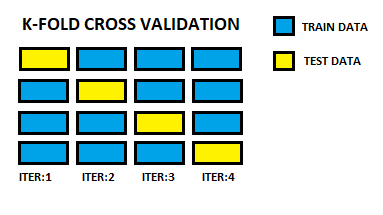

**Cross-Validation in sklearn**
- Let's now experiment with k-fold CV.

## K-Fold CV

In [ ]:
# k-fold CV (using all variables)
model = LGBMRegressor()
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
scores

array([-0.00880108, -0.00871458, -0.00878146, -0.00882744, -0.0087807 ])

In [ ]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0xC0FFEE)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=folds)
scores

array([-0.00879049, -0.00876683, -0.00875427, -0.00879073, -0.00881414])

## Grid Search CV
- A common use of cross-validation is for tuning hyperparameters of a model. The most common technique is what is called grid search cross-validation.

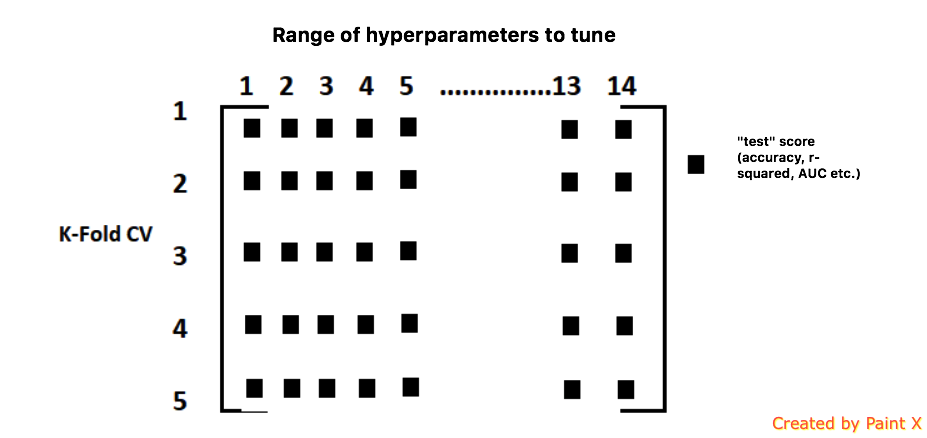

In [ ]:
# number of features in X_train
len(X_train.columns)

28

In [ ]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 0xC0FFEE)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 29))}]


# step-3: perform grid search
# 3.1 specify model
model = LGBMRegressor()
model.fit(X_train, y_train)
rfe = RFE(model)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params,
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        verbose = 2,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ............................n_features_to_select=25; total time=  26.6s
[CV] END ............................n_features_to_select=25; total time=  27.7s
[CV] END ............................n_features_to_select=25; total time=  25.8s
[CV] END ............................n_features_to_select=25; total time=  25.4s
[CV] END ............................n_features_to_select=25; total time=  26.8s
[CV] END ............................n_features_to_select=26; total time=  20.4s
[CV] END ............................n_features_to_select=26; total time=  20.3s
[CV] END ............................n_features_to_select=26; total time=  19.4s
[CV] END ............................n_features_to_select=26; total time=  19.5s
[CV] END ............................n_features_to_select=26; total time=  20.3s
[CV] END ............................n_features_to_select=27; total time=  13.7s
[CV] END ............................n_features_t

GridSearchCV(cv=KFold(n_splits=5, random_state=12648430, shuffle=True),
             estimator=RFE(estimator=LGBMRegressor()),
             param_grid=[{'n_features_to_select': [25, 26, 27, 28]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,25.817939,0.805728,0.648022,0.043052,25,{'n_features_to_select': 25},-0.008778,-0.008767,-0.008764,-0.008758,-0.008814,-0.008776,0.000020,1,-0.008730,-0.008744,-0.008738,-0.008727,-0.008760,-0.008740,0.000012
1,19.328135,0.451406,0.641060,0.021085,26,{'n_features_to_select': 26},-0.008792,-0.008756,-0.008765,-0.008773,-0.008820,-0.008781,0.000023,3,-0.008746,-0.008734,-0.008740,-0.008738,-0.008765,-0.008745,0.000011
2,13.253185,0.656419,0.587603,0.040261,27,{'n_features_to_select': 27},-0.008786,-0.008757,-0.008754,-0.008780,-0.008814,-0.008778,0.000022,2,-0.008743,-0.008734,-0.008731,-0.008749,-0.008758,-0.008743,0.000010
3,6.783793,0.187931,0.636372,0.036449,28,{'n_features_to_select': 28},-0.008790,-0.008767,-0.008754,-0.008791,-0.008814,-0.008783,0.000021,4,-0.008746,-0.008745,-0.008731,-0.008761,-0.008758,-0.008748,0.000011


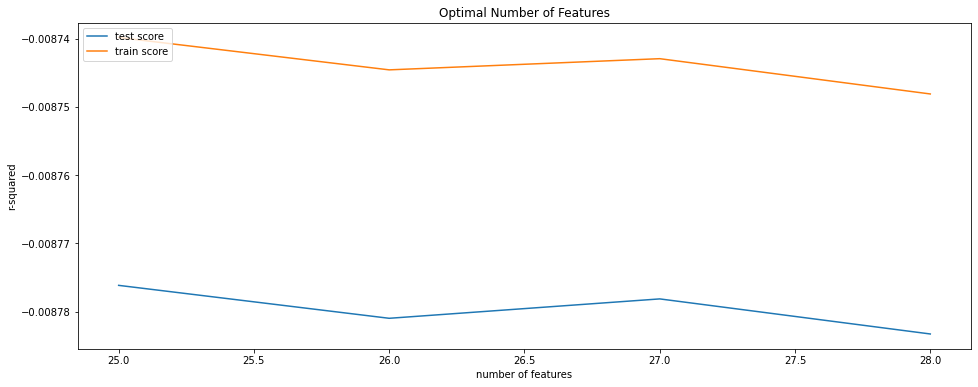

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
stop

## Optuna

In [ ]:
def objective(trial):
    
    param = {
        'objective': 'regression', # 회귀
        'verbose': 1,
        'metric': 'mse', 
        'max_depth': trial.suggest_int('max_depth',5, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=1, early_stopping_rounds=25)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    return mse

sampler = TPESampler(seed=42)
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-06-08 18:25:55,060] A new study created in memory with name: no-name-a47908fc-faae-412c-b52e-9547f8c967dd
[I 2022-06-08 18:26:03,619] Trial 0 finished with value: 0.0068769915449991515 and parameters: {'max_depth': 5, 'n_estimators': 100, 'min_child_samples': 6, 'subsample': 0.7943995963960729}. Best is trial 0 with value: 0.0068769915449991515.
[I 2022-06-08 18:26:10,513] Trial 1 finished with value: 0.007471730734264105 and parameters: {'max_depth': 4, 'n_estimators': 100, 'min_child_samples': 5, 'subsample': 0.8029815922829752}. Best is trial 0 with value: 0.0068769915449991515.
[I 2022-06-08 18:26:15,567] Trial 2 finished with value: 0.008709481322093258 and parameters: {'max_depth': 3, 'n_estimators': 100, 'min_child_samples': 7, 'subsample': 0.9581937809264416}. Best is trial 0 with value: 0.0068769915449991515.
[I 2022-06-08 18:26:20,177] Trial 3 finished with value: 0.00869970863091212 and parameters: {'max_depth': 3, 'n_estimators': 101, 'min_child_samples': 7, 'subsam

In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.006864753932530406,
params {'max_depth': 5, 'n_estimators': 100, 'min_child_samples': 7, 'subsample': 0.7698715745641292}


In [ ]:
# 시각화
optuna.visualization.plot_optimization_history(study_lgb)

In [ ]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study_lgb)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study_lgb)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study_lgb,
    params=[
        "max_depth",
        "n_estimators",
        "min_child_samples",
        "subsample",
    ],
)

In [ ]:
final_model = LGBMRegressor(**trial_params)
final_model.fit(X_train, y_train)
final_pred = final_lgb_model.predict(X_test)
print(f"MSE : {mean_squared_error(y_test, final_pred):.3}")
print(f"MAE : {mean_absolute_error(y_test, final_pred):.3}")

# Evaluation

In [ ]:
test = pd.read_csv('../data/test_V2.csv')
submission = pd.read_csv('../data/sample_submission_V2.csv')
real_y = submission['winPlacePerc']

In [ ]:
def feature_engineering(data):
    # add feature columns
    data['playersJoined'] = data.groupby('matchId')['matchId'].transform('count')
    data['killsNorm'] = data['kills']*((100-data['playersJoined'])/100 + 1)
    data['damageDealtNorm'] = data['damageDealt']*((100-data['playersJoined'])/100 + 1)
    data['healsAndBoosts'] = data['heals']+data['boosts']
    data['totalDistance'] = data['walkDistance']+data['rideDistance']+data['swimDistance']
    data['boostsPerWalkDistance'] = data['boosts']/(data['walkDistance']+1)
    data['boostsPerWalkDistance'].fillna(0, inplace=True)
    data['healsPerWalkDistance'] = data['heals']/(data['walkDistance']+1)
    data['healsPerWalkDistance'].fillna(0, inplace=True)
    data['healsAndBoostsPerWalkDistance'] = data['healsAndBoosts']/(data['walkDistance']+1)
    data['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
    data['killsPerWalkDistance'] = data['kills']/(data['walkDistance']+1)
    data['killsPerWalkDistance'].fillna(0, inplace=True)
    data.loc[data['matchType'].isin(["solo-fpp","solo","normal-solo-fpp","normal-solo"]), 'team']= 1
    data.loc[data['matchType'].isin(["duo-fpp","duo","normal-duo-fpp","normal-duo"]), 'team'] = 2
    data.loc[data['matchType'].isin(["squad-fpp","squad","normal-squad-fpp","normal-squad"]), 'team'] = 3
    return data

In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess(data, isTrain=False):
    # eliminate abnormal data(train)
    if isTrain:
        abnormal = data[data['winPlacePerc'].isna()].index.to_list()
        data.drop(abnormal, inplace=True)
        rows = data.loc[train['team']==0].index
        data.drop(rows, inplace=True)
        data.reset_index(inplace=True)
        y = data['winPlacePerc']
    # change abnormal data
    data.loc[data['winPoints']==0, 'winPoints'] = 1500
    # filter data
    X = data.loc[:, ['assists', 'damageDealt', 'DBNOs', 'heals',
       'killPlace', 'kills', 'boosts', 
       'killStreaks', 'longestKill', 'rankPoints', 'revives', 'rideDistance',
       'swimDistance', 'teamKills', 'walkDistance',
       'weaponsAcquired', 'winPoints', 
       'killsNorm', 'damageDealtNorm', 'healsAndBoosts', 'totalDistance',
       'boostsPerWalkDistance', 'healsPerWalkDistance',
       'healsAndBoostsPerWalkDistance', 'killsPerWalkDistance']]
    # one-hot encoding
    team = pd.get_dummies(data['team'])
    team.columns = ['solo', 'duo', 'squad']
    # scaling and concat with encoding data
    X_list = X.columns
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X_list)
    X_scaled = pd.concat([X_scaled, team], axis=1)
    return X_scaled if not isTrain else [X_scaled, y]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_models(models, X, y):
    for model in models:
        pred = model.predict(X)
        print(f"MSE : {mean_squared_error(y, pred):.3}")
        print(f"MAE : {mean_absolute_error(y, pred):.3}")
        print("=====")

In [ ]:
test = pd.read_csv('../data/test_V2.csv', dtype=dtypes)
submission = pd.read_csv('../data/sample_submission_V2.csv', dtype=dtypes)

In [ ]:
f_X = feature_engineering(test)
X = preprocess(f_X)

In [ ]:
evaluate_models([model], real_X, real_y)